In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scikitplot.metrics import plot_roc
from sklearn.model_selection import train_test_split

In [2]:
dev_df = pd.read_csv('data/train.csv')
del dev_df["Id"]
dev_df = dev_df.drop_duplicates().copy()
dev_df["Prediction"] = dev_df["Prediction"].apply(lambda x: 1 if x == "s" else 0)

train_df, val_df = train_test_split(dev_df, test_size=0.2, stratify=dev_df["Prediction"])
train_df, val_df = train_df.reset_index(drop=True).copy(), val_df.reset_index(drop=True).copy()

test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.head()

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,1,109.012,49.577,72.804,18.844,-999.000,-999.000,-999.000,3.025,18.844,...,0.446,151.242,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000
1,1,107.801,3.840,58.375,135.370,4.425,466.792,-4.872,1.828,17.417,...,2.666,252.600,2,88.196,2.365,-0.531,30.245,-2.060,-0.734,118.440
2,0,-999.000,133.262,81.737,85.071,-999.000,-999.000,-999.000,2.055,10.073,...,-1.750,284.001,1,80.383,3.101,2.456,-999.000,-999.000,-999.000,80.383
3,0,125.353,69.184,102.844,106.850,1.015,59.288,-0.186,2.055,2.025,...,-0.451,158.298,2,59.084,0.240,-2.383,49.013,-0.775,-2.317,108.097
4,0,144.944,84.647,78.277,5.083,-999.000,-999.000,-999.000,3.032,5.083,...,0.909,109.755,0,-999.000,-999.000,-999.000,-999.000,-999.000,-999.000,0.000


In [4]:
train_df.describe()

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.342670,-49.326649,49.187113,81.118475,57.987970,-707.863189,-600.612700,-708.799119,2.371657,18.954454,...,-0.010650,209.971244,0.980760,-347.291416,-398.327144,-398.332515,-691.795957,-708.564614,-708.561783,73.199789
std,0.474603,406.502961,35.312730,40.726414,63.704765,454.736698,658.203993,453.277985,0.782423,22.469347,...,1.812286,126.534481,0.977422,532.783978,489.148793,489.144487,480.139511,453.641469,453.645629,97.945362
min,0.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,-3.142000,17.931000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
25%,0.000000,78.053750,19.224000,59.381000,14.208750,-999.000000,-999.000000,-999.000000,1.808000,2.846000,...,-1.574000,123.081750,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000
50%,0.000000,104.996000,46.475000,73.742500,38.530000,-999.000000,-999.000000,-999.000000,2.489000,12.416000,...,-0.027000,179.930500,1.000000,39.016000,-1.861000,-2.084000,-999.000000,-999.000000,-999.000000,40.605500
75%,1.000000,130.537250,73.513000,92.185000,79.426500,0.491000,83.726750,-4.548000,2.960000,27.617000,...,1.561000,263.560750,2.000000,75.568500,0.438000,0.513000,33.756000,-2.437000,-2.262750,110.289250
max,1.000000,1192.026000,690.075000,1349.351000,2834.999000,8.459000,4974.979000,16.690000,5.655000,2834.999000,...,3.142000,1733.037000,3.000000,755.235000,4.499000,3.141000,706.672000,4.500000,3.142000,1633.433000


<AxesSubplot:>

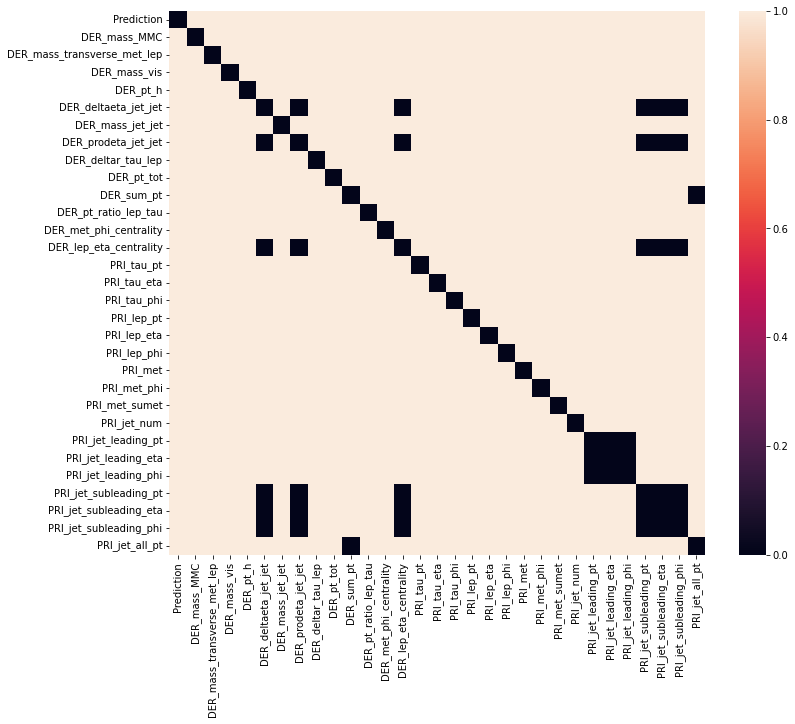

In [5]:
corrMatrix = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap((corrMatrix < 0.95) & (-0.95 < corrMatrix))

In [6]:
useless = [
    'DER_deltaeta_jet_jet', 
    'DER_prodeta_jet_jet',
    'DER_lep_eta_centrality', 
    'PRI_jet_subleading_eta',
    'PRI_jet_subleading_phi', 
    'PRI_jet_leading_eta', 
    'PRI_jet_leading_phi', 
    'DER_sum_pt', 
]

for col in useless:
    del train_df[col]

<AxesSubplot:>

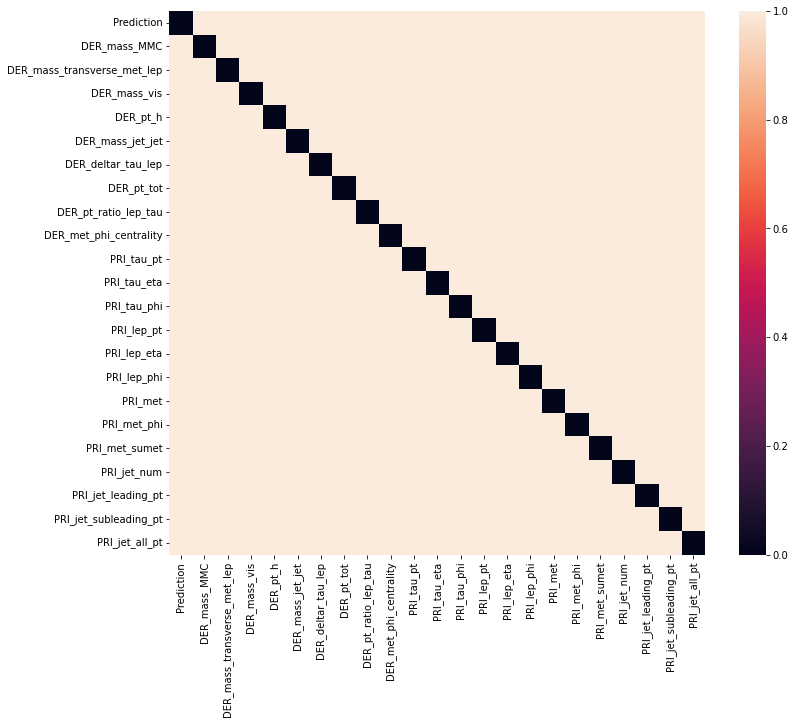

In [7]:
corrMatrix = train_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap((corrMatrix < 0.95) & (-0.95 < corrMatrix))

<AxesSubplot:>

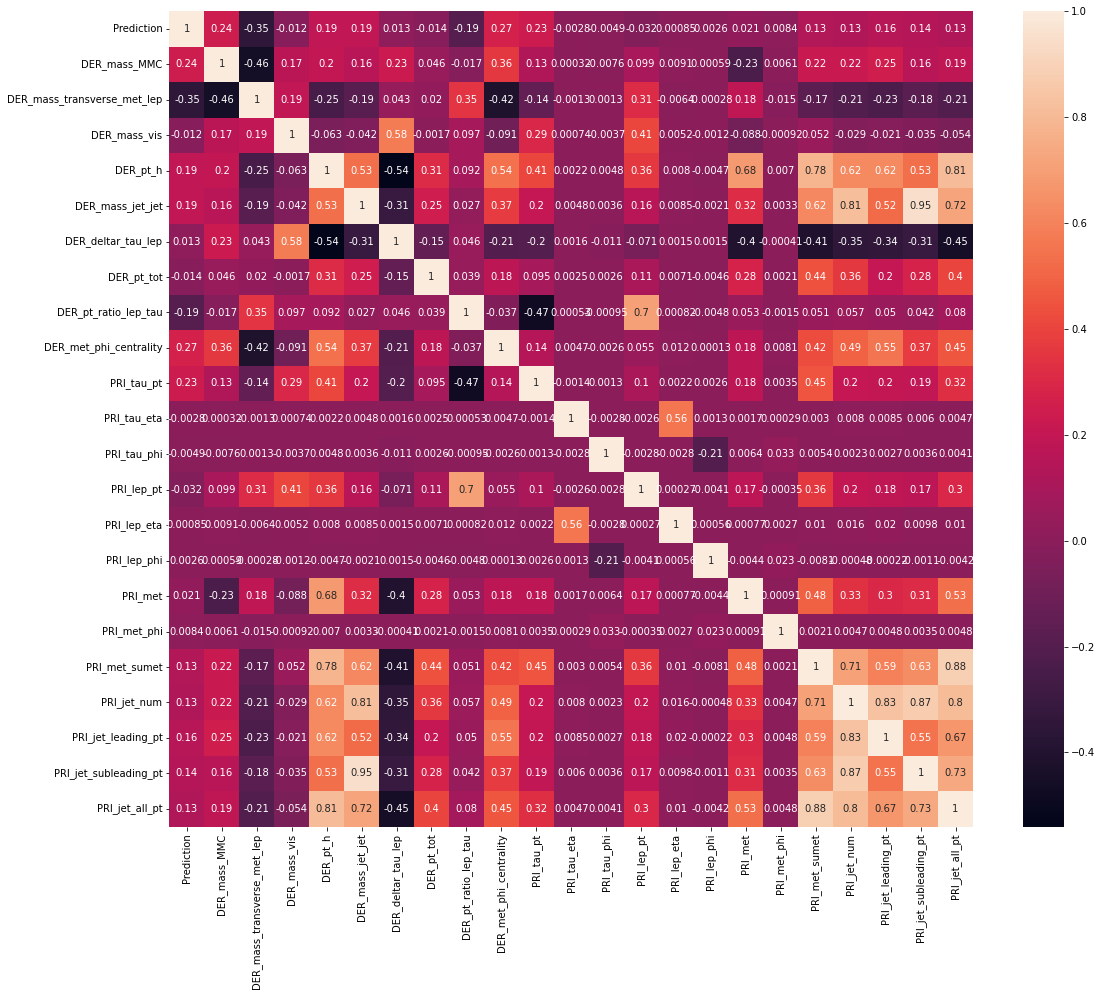

In [8]:
plt.figure(figsize=(18,15))
corrMatrix = train_df.corr()
sns.heatmap(corrMatrix, annot=True)

In [9]:
import numpy as np

In [10]:
train_df[train_df < -999.000] = np.nan
train_df.fillna(train_df.mean(), inplace=True)

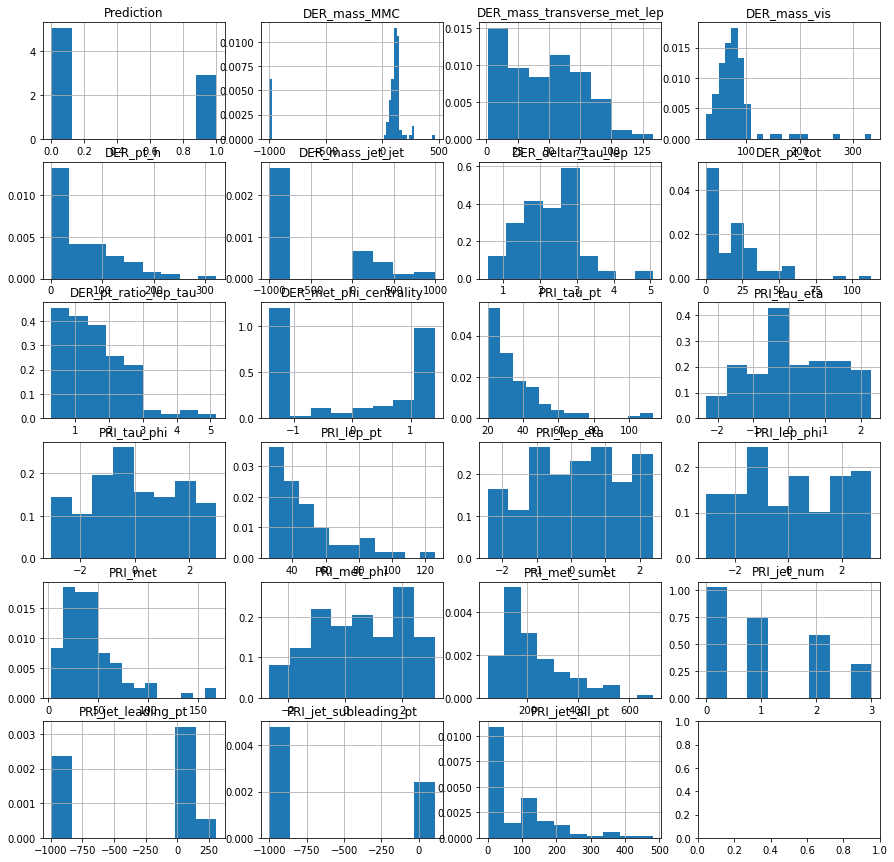

In [11]:
fig, axs = plt.subplots(6, 4, figsize=(15,15))
columns = train_df.columns
for i in range(23):
    train_df.loc[:100, columns[i]].hist(
        bins="auto", 
        density=True, 
        ax=axs[i // 4, i % 4], 
    )
    axs[i // 4, i % 4].set_title(columns[i])

In [12]:
from implementations import ridge_regression

In [13]:
train_df

,Prediction,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_mass_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,...,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_subleading_pt,PRI_jet_all_pt
0,1,109.012,49.577,72.804,18.844,-999.000,3.025,18.844,0.951,-1.381,...,33.703,1.328,-3.014,18.701,0.446,151.242,0,-999.000,-999.000,0.000
1,1,107.801,3.840,58.375,135.370,466.792,1.828,17.417,2.044,1.073,...,43.709,1.227,2.731,79.793,2.666,252.600,2,88.196,30.245,118.440
2,0,-999.000,133.262,81.737,85.071,-999.000,2.055,10.073,4.132,-1.389,...,96.703,0.390,0.065,73.958,-1.750,284.001,1,80.383,-999.000,80.383
3,0,125.353,69.184,102.844,106.850,59.288,2.055,2.025,3.656,-0.419,...,91.148,0.052,0.891,33.947,-0.451,158.298,2,59.084,49.013,108.097
4,0,144.944,84.647,78.277,5.083,-999.000,3.032,5.083,2.382,-1.317,...,59.869,-0.108,-2.137,29.988,0.909,109.755,0,-999.000,-999.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,64.580,41.032,51.907,1.897,-999.000,2.593,1.897,1.224,-1.405,...,29.221,-0.696,-0.595,17.915,-2.819,66.638,0,-999.000,-999.000,0.000
199996,0,101.745,30.226,70.918,28.930,-999.000,2.829,5.888,1.204,1.414,...,39.083,0.292,0.042,16.212,-1.246,143.034,1,32.048,-999.000,32.048
199997,0,85.151,61.879,62.622,23.818,-999.000,2.446,13.837,2.144,-0.457,...,45.804,1.558,0.495,21.268,-2.382,152.577,1,36.092,-999.000,36.092
199998,0,95.557,43.793,78.455,1.186,-999.000,2.666,1.186,1.034,-1.414,...,41.025,0.702,-2.400,17.874,-0.517,85.865,0,-999.000,-999.000,0.000


In [14]:
train_df = pd.concat([train_df, pd.get_dummies(train_df["PRI_jet_num"], prefix='PRI_jet_num')], axis=1).copy()
del train_df["PRI_jet_num"]
val_df = pd.concat([val_df, pd.get_dummies(val_df["PRI_jet_num"], prefix='PRI_jet_num')], axis=1).copy()
del val_df["PRI_jet_num"]
test_df = pd.concat([test_df, pd.get_dummies(test_df["PRI_jet_num"], prefix='PRI_jet_num')], axis=1).copy()
del test_df["PRI_jet_num"]


In [17]:
y_column = "Prediction"
X_columns = [col for col in train_df.columns if col != y_column]

In [31]:
X_train, y_train = train_df[X_columns].values, train_df[y_column].values
X_val, y_val = val_df[X_columns].values, val_df[y_column].values

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

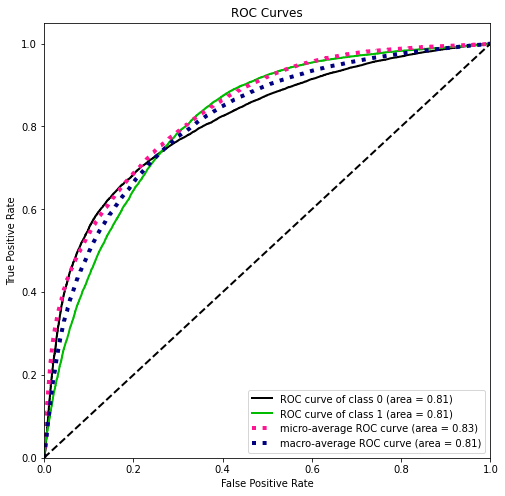

In [55]:
w_pure = ridge_regression(y, X, lambda_=0.)
y_pred = (X_val @ w_pure).reshape(-1, 1)
y_pred = np.concatenate([1 - y_pred, y_pred], axis=1)
plot_roc(y_val, y_pred, figsize=(8,8))